In [1]:
# ! pip install numpy pandas pillow jinja2

In [2]:
import base64
import tarfile

import numpy as np
import pandas as pd
from PIL import Image

In [3]:
tar = tarfile.open('images.tar')

def get_image(idx):
    return Image.open(tar.extractfile(f"{idx}.jpg"))

def embed_image(idx):
    image_base64 = base64.b64encode(tar.extractfile(f"{idx}.jpg").read()).decode('ascii')
    return f'<img src="data:image/jpeg;base64,{image_base64}" />'

,Mario,Frieren,Lae'zel
0,,,

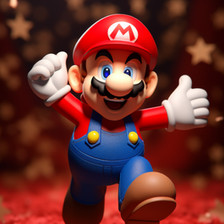
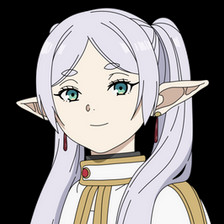
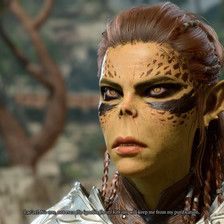

In [4]:
# These are different characters we want to classify:

characters = ["Mario", "Frieren", "Lae'zel"]
examples = [56340, 30180, 49582]

pd.DataFrame([examples], columns=characters).style.format(embed_image)

,0,1,2,3,4
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,

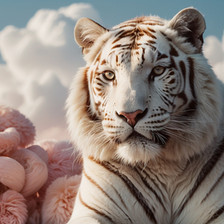
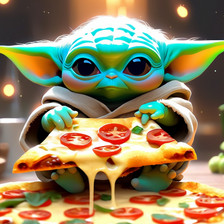
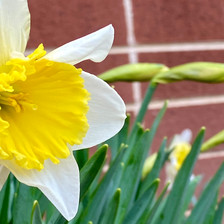
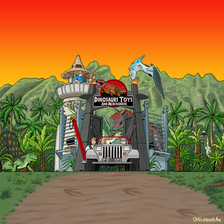
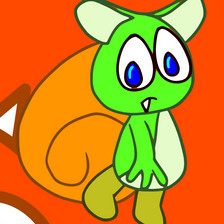
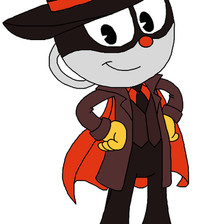
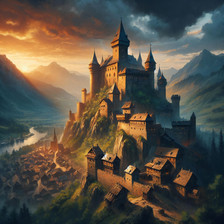
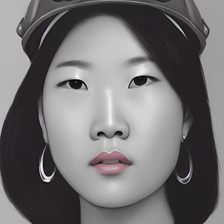
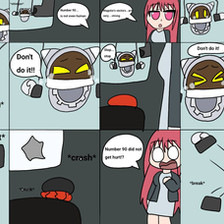
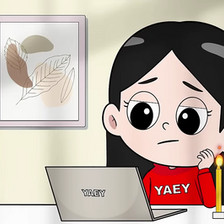
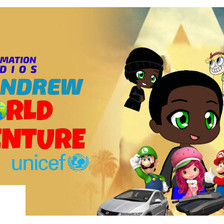
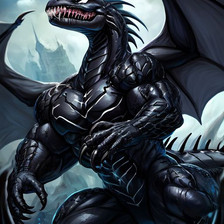
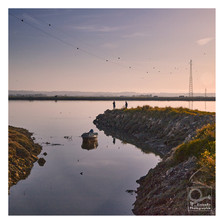
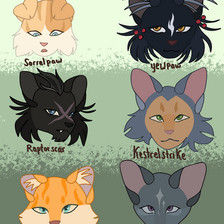
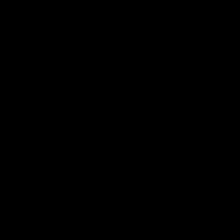
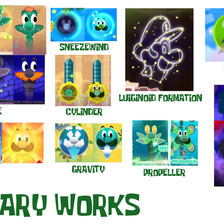
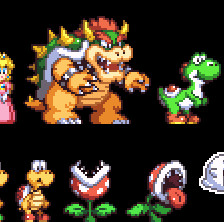
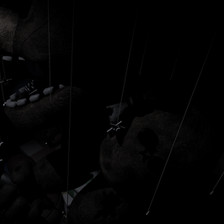
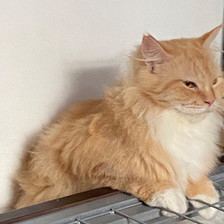
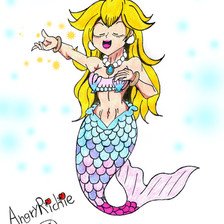
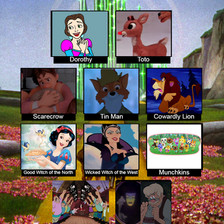
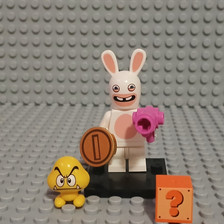
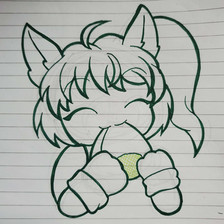
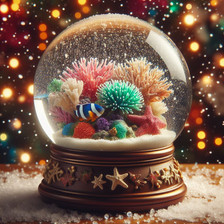
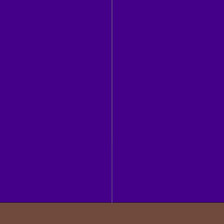

In [5]:
# Some images from the dataset:
np.random.seed(5)
pd.DataFrame(np.random.randint(0, len(tar.getmembers()), 25).reshape(5, 5)).style.format(embed_image)

In [6]:
embeddings = np.load('image_embeddings.npy')
embeddings.shape

(92350, 512)

# Classifier

In [8]:
# classifier code goes here

In [9]:
## Importing Libraries and models.
## I will use CLIP model available in the transformes library of Hugging Face platform.
## I am going to use CPU for this task becuase I am not going to train a model.

from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [10]:
## Checking if the values provided as image embeddings are equal to the image embeddings that the clip model will provide given the same image.

idx = 64651
image = get_image(idx)
image = processor(text=None,images=image,return_tensors='pt')['pixel_values'].to(device)
img_emb = model.get_image_features(image)
img_emb = img_emb.detach().numpy()
print(f'The norm of defference of dataset embedding array and image embedding provided by CLIP is {np.linalg.norm(embeddings[64651]- img_emb)}')
print('The norm of the difference is very small, so the provided embeddings are derived from the CLIP model')


The norm of defference of dataset embedding array and image embedding provided by CLIP is 2.5219767849193886e-05
The norm of the difference is very small, so the provided embeddings are derived from the CLIP model


In [214]:
## now we implement the rest of the CLIP model code for zero shot image classification
## CLIP model is traiend for classifying an image given using text labels,meaning it will choose the label with the highest probabaility.
## However, most of the images are not any of the mentioned characters that we want to classifiy the images with.
## As a result instead of choosing a the label with highest possibility among the others, I use a treshold, and the label with probability higher than the treshold will be chosen.

## defininf the phto id, characters and the treshold I want to use for my model
idx = 64651
characters = ["Mario", "Frieren", "Lae'zel"]
threshold = 0.98

def CLIP(idx, characters, threshold):

    ## normalaizing image embeddings provided in the dataset

    img_emb = torch.from_numpy(embeddings[idx])
    img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
    img_emb = img_emb.detach().cpu()


    ## calculating and normalaizing lables embeddings 

    label_tokens = processor(text=characters,padding=True,return_tensors='pt').to(device)
    label_emb = model.get_text_features(**label_tokens)
    label_emb = label_emb / label_emb.norm(p=2, dim=-1, keepdim=True)
    label_emb = label_emb.detach().cpu()

    ## finding the similarities of image and lables embeddings using dot product

    logit_scale = 100
    logits_per_text = torch.matmul(label_emb, img_emb.t()) * logit_scale
    logits_per_image = logits_per_text.t()

    ## calculating the probabilities of lables using the similarity array and SoftMax function
    probs = logits_per_image.softmax(dim=-1).squeeze()

    ## using the treshold for choosing the correct label
    return np.where(probs > threshold, 1, 0)

if 1 in CLIP(idx, characters, threshold):
    print(f'This is a photo of {characters[CLIP(idx, characters, threshold).argmax()]}.')
else:
    print('THis is a photo of none of the mentioned characters.')

This is a photo of Mario.


# Evaluation

In [12]:
# evaluation code goes here

In [215]:
test_set = pd.read_csv("test_set.csv")
test_set

,index,Mario,Frieren,Lae'zel
0,4134,0.0,0.0,0.0
1,11673,0.0,0.0,0.0
2,42508,0.0,0.0,0.0
3,61900,0.0,0.0,0.0
4,64651,1.0,0.0,0.0
...,...,...,...,...
95,9029,1.0,0.0,0.0
96,55870,0.0,0.0,0.0
97,91829,0.0,0.0,0.0
98,55147,0.0,0.0,0.0


In [206]:
## Import evaluation metrics libraries for multi-class classification 

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [216]:
## Making an array of precicted labels using photos that are in test_set
## I will make a label 4 if the picture is not any of the mentioned charaters

df=pd.DataFrame([CLIP(i, characters, threshold) for i in test_set['index']])
df[3]=0 
df[3] = df.eq(0).all(axis=1).astype(int)
preds = np.argmax(df.values, axis=1)
print(f'Pridicted lables for the photos in the test set (witht he same order) are:',preds[:])

Pridicted lables for the photos in the test set (witht he same order) are: [3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 0 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3
 3 3 0 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3]


In [201]:
## Making an array of test_set predicted labels
## Same as above, I will make a label 4 if the picture is not any of the mentioned charaters

test_set = test_set.astype('int')
test_set.drop(columns="index", inplace = True)
test_set["other"]=0 
test_set['other'] = test_set.eq(0).all(axis=1).astype(int)
test_preds = np.argmax(test_set.values, axis=1)
print(f'test_ser lables are:',test_preds[:])

test_ser lables are: [3 3 3 3 0 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 0 3 3 3 3 3 3 3 3 0 3 3 3 3
 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 0 3 0 3 3 3 3 3 3 3 3 0 3 3 3 3]


In [217]:
## Calculating Accuracy, recall, orecision and f_score of the model using weighted average.

accuracy = accuracy_score(test_preds, preds)
print("Accuracy:", accuracy)
f1 = f1_score(test_preds, preds, average='weighted')
print("F1 Score:", f1)
recall = recall_score(test_preds, preds, average='weighted')
print("Recall:", recall)
precision = precision_score(test_preds, preds, average='weighted')
print("Precision:", precision)

Accuracy: 0.93
F1 Score: 0.9285245901639344
Recall: 0.93
Precision: 0.9275776397515527
